In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# Imports
import os
import pandas as pd
from dw_events.temperature_compensation.kalman_filter import KalmanTempComp, KalmanFilter
from dw_events.data.make_dataset import DataGetter
from dw_events.data.utils import make_dt_list, get_dataframe_str_subset
import datetime
import matplotlib.pyplot as plt

In [2]:
start = datetime.datetime(2022, 9, 1)
end = datetime.datetime(2022, 9, 2)
datagetter = DataGetter(start, end)
strain_data = datagetter.get_strain_data()

In [4]:
# Get strain line data BCN
BCN_signals = datagetter.get_dataframe_str_subset('BCN')

In [39]:
BCN_signals.index[800000]

Timestamp('2022-09-01 09:05:08.400000+0000', tz='UTC')

In [5]:
BCN_signals.iloc[:,3]

time
2022-08-31 22:00:00+00:00           240.4
2022-08-31 22:00:00.050000+00:00    240.4
2022-08-31 22:00:00.100000+00:00    240.4
2022-08-31 22:00:00.150000+00:00    240.2
2022-08-31 22:00:00.200000+00:00    240.2
                                    ...  
2022-09-01 21:59:59.750000+00:00    264.6
2022-09-01 21:59:59.800000+00:00    264.8
2022-09-01 21:59:59.850000+00:00    264.6
2022-09-01 21:59:59.900000+00:00    264.8
2022-09-01 21:59:59.950000+00:00    264.5
Name: SCB_ALM_BCN_FBG_HOR008_0_nr4, Length: 1729767, dtype: float64

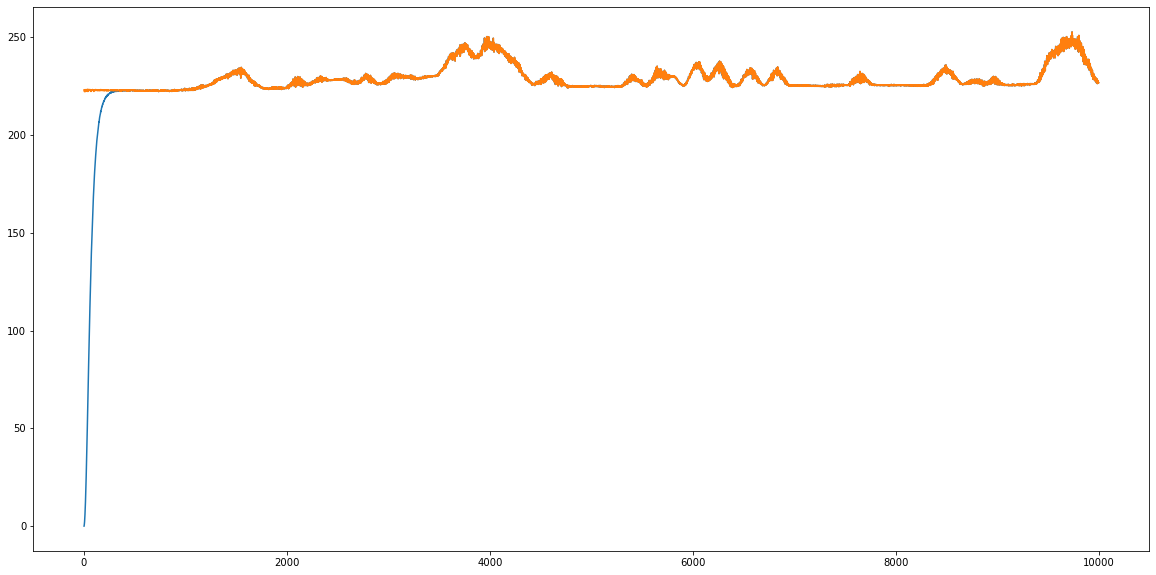

In [88]:
series = []
start = 800000
stop = 810000

kalman_temp_comp = \
    KalmanTempComp(
        measurement_uncertainty = 1000,
        delta = 1e-5)

for idx, row in BCN_signals.iloc[start:stop,3:4].iterrows():
    x, P, K, z_hat = kalman_temp_comp.iterate(row[0])
    series.append(z_hat.squeeze())

# Plot the combined portfolio
plt.figure(figsize=(20,10))
plt.plot(series[1:])
plt.plot(BCN_signals.iloc[start:stop,3].values)

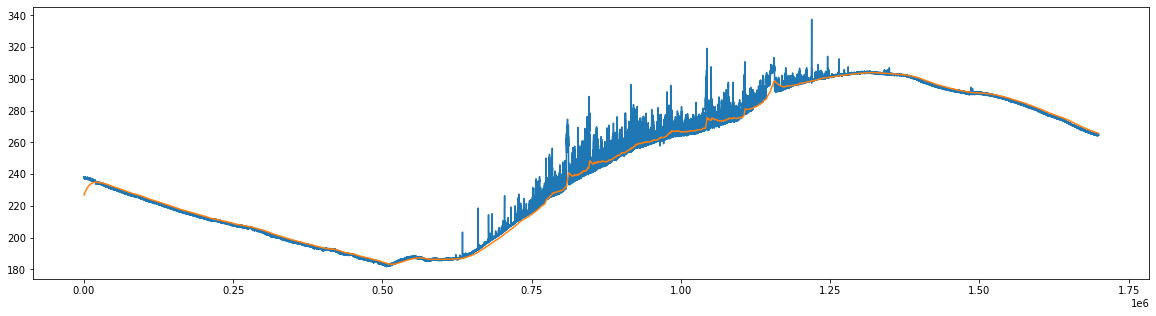

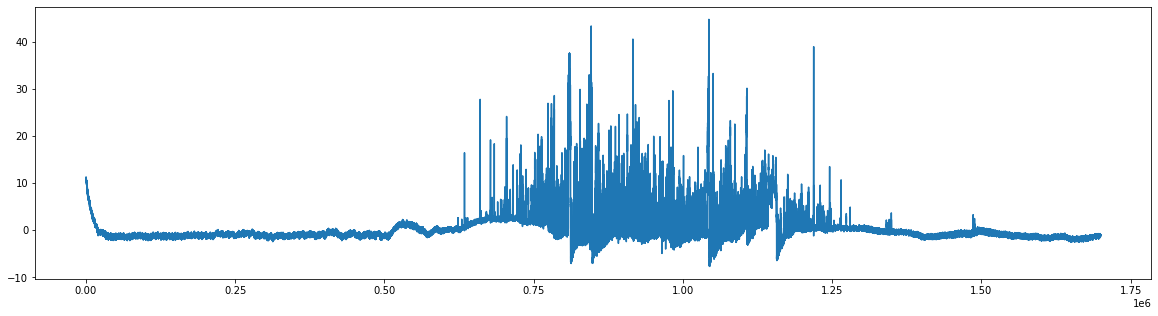

In [92]:
start = 0
stop = 5000000

kf = KalmanFilter(1e-4, 10000)
series = []
for idx, row in BCN_signals.iloc[start:stop,3:4].iterrows():
    kf.input_latest_noisy_measurement(row[0])
    series.append(kf.get_latest_estimated_measurement())

# Plot the combined portfolio
plt.figure(figsize=(20,5))
start_series = 30000
plt.plot(BCN_signals.iloc[start+start_series:stop,3].values)
plt.plot(series[start_series:])

plt.show()
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(BCN_signals.iloc[start+start_series:stop,3].values - series[start_series:])